<a href="https://colab.research.google.com/github/akkinepally/categorize-cognitive-processes/blob/main/human_memory_and_cognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np 

# Load Data

In [2]:
train_data = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/hippocorpus/train_set_label.csv" )

In [3]:
train_data.head()

,AssignmentId,WorkTimeInSeconds,WorkerId,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,mostSurprising,openness,recAgnPairId,recImgPairId,similarity,similarityReason,story,stressful,summary,timeSinceEvent,memType
0,39DD6S19JQXBBJGPFEBWSF4G1TQEZJ,1025,YGROBIBW,35.0,Man,white,one,3.0,2.0,3.0,4.094345,my friend's death and how our group of friends...,the mourning process had a kind of positive si...,0.375,3RKNTXVS3NKSI9BOEGJK201G4H2A46,NaN,NaN,NaN,We were friends from high school. I got a call...,3.0,my friend's death. Old friends reunited to sha...,60.0,retold
1,3WQQ9FUS6BGYKK3IWX9TEN1R8RLB87,1987,KK89LEHY,35.0,woman,indian,one,5.0,3.0,5.0,5.010635,the loss of my father and the impact he had on...,he died very suddenly and within minutes,0.625,NaN,3WQQ9FUS6BGYKK3IWX9TEN1R8RLB87,NaN,NaN,"Five months ago, my father passed away from a ...",2.0,"My dad, who was a significant person in my lif...",150.0,recalled
2,3YDTZAI2WY2WOLYOIXQRRZ8DKXB14S,1604,JIWFAU5T,35.0,man,White,one,one,5.0,5.0,4.787492,how I met my wife.,when I got my unreserved kind of love.,1.000,NaN,3YDTZAI2WY2WOLYOIXQRRZ8DKXB14S,NaN,NaN,My Most Memorable Day of My Life! I found my o...,1.0,The best thing may be difficult to find. I was...,120.0,recalled
3,3Q8GYXHFEQOY77CMCZYLDNXJ2YBC58,6369,1NHCDDOJ,40.0,woman,white,one,one,NaN,4.0,5.480639,the events leading up to my wedding,a surprise flash mob wedding proposal,0.875,NaN,3WLEIWSYHP3XPI4FG8AOQ7RM04VH26,1.0,"This was not at all how I got engaged, but a w...",It has been such a whirlwind these past 8 mont...,1.0,The event described details my wedding which o...,240.0,imagined
4,32AT8R96GMVVZ3RXAMWT04TG9CISU0,1083,A5SWJWSQ,30.0,MAN,white,one,5.0,3.0,5.0,4.094345,Attending a funeral for my cousin.,How emotional I felt during at the cemetery.,1.000,NaN,32AT8R96GMVVZ3RXAMWT04TG9CISU0,NaN,NaN,Today was one of the saddest days of my life. ...,4.0,My cousin recently passed away due to brain ca...,60.0,recalled


# Exploratory Data Analysis

In [4]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6797 entries, 0 to 6796
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AssignmentId       6797 non-null   object 
 1   WorkTimeInSeconds  6797 non-null   int64  
 2   WorkerId           6797 non-null   object 
 3   annotatorAge       6771 non-null   float64
 4   annotatorGender    6793 non-null   object 
 5   annotatorRace      6797 non-null   object 
 6   distracted         6797 non-null   object 
 7   draining           6797 non-null   object 
 8   frequency          4052 non-null   float64
 9   importance         6649 non-null   float64
 10  logTimeSinceEvent  6797 non-null   float64
 11  mainEvent          6797 non-null   object 
 12  mostSurprising     6797 non-null   object 
 13  openness           6797 non-null   float64
 14  recAgnPairId       2549 non-null   object 
 15  recImgPairId       5303 non-null   object 
 16  similarity         2745 

In [5]:
train_data.isnull().sum()

AssignmentId            0
WorkTimeInSeconds       0
WorkerId                0
annotatorAge           26
annotatorGender         4
annotatorRace           0
distracted              0
draining                0
frequency            2745
importance            148
logTimeSinceEvent       0
mainEvent               0
mostSurprising          0
openness                0
recAgnPairId         4248
recImgPairId         1494
similarity           4052
similarityReason     4052
story                   0
stressful               0
summary                 0
timeSinceEvent          0
memType                 0
dtype: int64

In [6]:
def preprocess_data(data):
  data['draining'] = data['draining'].replace('one', 1.0)
  data['distracted'] = data['distracted'].replace('one', 1.0)
  data = data.astype({'draining':float,'distracted':float })
  data['annotatorGender'] = data['annotatorGender'].replace(['Woman', 'WOMAN'], 'woman')
  data['annotatorGender'] = data['annotatorGender'].replace(['Man', 'MAN'], 'man')
  data['annotatorGender'] = data['annotatorGender'].replace(['Transman', 'TRANSMAN'], 'transman')
  data['annotatorGender'] = data['annotatorGender'].replace(['Transwoman', 'TRANSWOMAN'], 'transwoman')
  data['annotatorGender'] = data['annotatorGender'].replace(['na', 'Nonbinary', 'nonBinary', 'NONBINARY', 'Na'], 'other')
  data['annotatorGender'] = np.where(data['annotatorGender'].isin(['man', 'woman']), data['annotatorGender'], 'Other')
  data['annotatorRace'] = data['annotatorRace'].replace(['White'], 'white')
  data['annotatorRace'] = data['annotatorRace'].replace(['Black'], 'black')
  data['annotatorRace'] = np.where(data['annotatorRace'].isin(['white','black']), data['annotatorRace'], 'Other')
  data = data.drop(['recAgnPairId','recImgPairId', 'similarity', 'similarityReason','AssignmentId','WorkerId', 'mainEvent', 'similarityReason', 'story', 'summary', 'mostSurprising'], axis =1 )
  data = data.fillna(train_data.mean())
  le1 = LabelEncoder()
  le2 = LabelEncoder()
  data['annotatorGender'] = data[['annotatorGender']].apply(le1.fit_transform)
  data['annotatorRace'] = data[['annotatorRace']].apply(le2.fit_transform)
  return data

In [7]:
train_data = preprocess_data(train_data)

In [8]:
le3 = LabelEncoder()
train_data['memType'] = train_data[['memType']].apply(le3.fit_transform)

In [9]:
train_data['memType'].value_counts()

1    2760
0    2745
2    1292
Name: memType, dtype: int64

In [10]:
train_data.isnull().sum()

WorkTimeInSeconds    0
annotatorAge         0
annotatorGender      0
annotatorRace        0
distracted           0
draining             0
frequency            0
importance           0
logTimeSinceEvent    0
openness             0
stressful            0
timeSinceEvent       0
memType              0
dtype: int64

# Created a new feature using pretrained sentimentIntensityAnalyzer classifying them as positive and negative story or summary

In [27]:
import nltk
nltk.download('vader_lexicon')
sentiment_score = []
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sent = "I was surprised that The Shining was playing at the theater in town. I got to watch the movie, and it kicked ass and was perfect and made me happy."

score = sid.polarity_scores(sent)
score.pop('compound')
print(score)
max(score, key=score.get)



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
{'neg': 0.093, 'neu': 0.612, 'pos': 0.295}


'neu'

In [28]:
sent_label = []
for i in train_data['mostSurprising']:
  score = sid.polarity_scores(i)
  score.pop('compound')
  score.pop('neu')
  label = max(score, key=score.get)
  label = label.replace("'", "")
  sent_label.append(label)

In [29]:
train_data['sent_label'] =  sent_label

In [30]:
train_data[['sent_label', 'mostSurprising']]

,sent_label,mostSurprising
0,pos,the mourning process had a kind of positive si...
1,neg,he died very suddenly and within minutes
2,pos,when I got my unreserved kind of love.
3,pos,a surprise flash mob wedding proposal
4,pos,How emotional I felt during at the cemetery.
...,...,...
6792,neg,the car almost hit me.
6793,pos,"my dad passed away so suddenly, when there wer..."
6794,neg,how little rest me and my spouse got in the fo...
6795,neg,when my baby crawl for the first time in my pr...


In [31]:
train_data = train_data.drop(['mostSurprising'], axis = 1)

In [ ]:
le4 = LabelEncoder()
train_data['sent_label'] = train_data[['sent_label']].apply(le4.fit_transform)

# Splitting the data 


In [11]:
y = train_data['memType'].values
x = train_data.drop(['memType'], axis =1).values

# Splitting data to training and test 


In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

In [13]:
train_data.columns

Index(['WorkTimeInSeconds', 'annotatorAge', 'annotatorGender', 'annotatorRace',
       'distracted', 'draining', 'frequency', 'importance',
       'logTimeSinceEvent', 'openness', 'stressful', 'timeSinceEvent',
       'memType'],
      dtype='object')

In [14]:
from imblearn.over_sampling import SMOTE
sm = SMOTE('minority')
x_train, y_train = sm.fit_sample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [22]:
feature_names = ['WorkTimeInSeconds', 'annotatorAge', 'annotatorGender', 'annotatorRace',
       'distracted', 'draining', 'frequency', 'importance',
       'logTimeSinceEvent', 'openness', 'stressful', 'timeSinceEvent','sent_label']
model = XGBClassifier(feature_names=feature_names) 
model.fit(x_train, y_train)
model.feature_importances_

array([0.02769426, 0.02446976, 0.02751647, 0.01272485, 0.06227756,
       0.02537772, 0.48173293, 0.05096297, 0.10081156, 0.01643974,
       0.02669424, 0.14329803], dtype=float32)

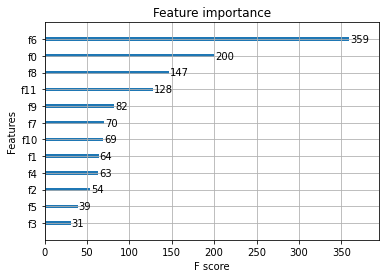

In [23]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model, )
pyplot.show()

# Model Evaluation

In [24]:
y_pred_train = model.predict(x_train)
train_accuracy = accuracy_score(y_train, y_pred_train) 

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred) 

print("train Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

train Accuracy: 91.01%
Accuracy: 88.53%


# Load the validation data


In [25]:
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/hippocorpus/test_set_label.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AssignmentId       2057 non-null   object 
 1   WorkTimeInSeconds  2057 non-null   int64  
 2   WorkerId           2057 non-null   object 
 3   annotatorAge       2051 non-null   float64
 4   annotatorGender    2057 non-null   object 
 5   annotatorRace      2057 non-null   object 
 6   distracted         2057 non-null   object 
 7   draining           2057 non-null   object 
 8   frequency          1230 non-null   float64
 9   importance         2018 non-null   float64
 10  logTimeSinceEvent  2057 non-null   float64
 11  mainEvent          2057 non-null   object 
 12  mostSurprising     2057 non-null   object 
 13  openness           2057 non-null   float64
 14  recAgnPairId       811 non-null    object 
 15  recImgPairId       1595 non-null   object 
 16  similarity         827 n

# Preprocess the validation dataset

In [26]:
test_data = preprocess_data(test_data)

# Predictions on Validation Dataset


In [27]:
y_pred = model.predict(test_data.values)
y_pred = le3.inverse_transform(y_pred)
result_df = pd.DataFrame()
result_df['prediction'] = y_pred
result_df.reset_index(drop=True, inplace=True)
result_df.to_csv('sample_submission.csv', index = False)

In [28]:
# The accuracy on Validation dataset was 88%

result_df.head()


,prediction
0,imagined
1,recalled
2,recalled
3,retold
4,imagined
